# Tile Drainage Code

In [3]:
#import libraries
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns
import fiona

## 1. Importing WQP Data

In [4]:
def get_data(country=None, state=None, county=None, media=None, analytes=None, form="csv", providers=None, start_date=None, path=".", selected_cols=None):
    """
    Function get_data() imports data from the water quality portal given certain input parameters. 
    See https://www.waterqualitydata.us/#advanced=true for more info on paramters 
    Inputs:
        Country, state, county, media, analytes, form, providers, start_date : parameters defined in the portal
        Selected_col : a list of only the required columns from the portal output
    Outputs: 
        df : pandas datafame that contains only the selected columns of the waterquality portal data 
    """
    
    # Define the URL and parameters
    url = "https://www.waterqualitydata.us/data/Result/search"
    params = {}
    
    if country:
        params["countrycode"] = country
    if state:
        params["statecode"] = state
    if media:
        params["sampleMedia"] = media
    if analytes:
        params["characteristicName"] = analytes
    if form:
        params["mimeType"] = form
    if providers:
        params["providers"] = providers
    if start_date:
        params["startDateLo"] = start_date
    if county:
        params["countycode"] = county

    # Print the current working directory
    print("Current Working Directory:", os.getcwd())

    # Define the file path (customize if needed)
    file_path = os.path.join(path, "water_quality_data.csv")

    # Send the GET request
    response = requests.get(url, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Write the content to a CSV file
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"Data successfully downloaded and saved as '{file_path}'")

        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Filter the DataFrame if selected_cols is provided
        if selected_cols:
            df = df[selected_cols]
        df = df.dropna(subset=['ResultMeasureValue'])
       
    else:
        print("Failed to download data. Status code:", response.status_code)
        
    return df

In [5]:
# Get data for given parameters
country = "US"
state = "US:36"
county = None  # County is optional
media = ["water", "Water"]
analytes = ["Nitrate", "Nitrate as N", "Nitrate-N","Nitrate-nitrogen","Nitrate-Nitrogen"]
form = "csv"
providers = ["NWIS", "STORET"]
start_date = '01-01-2000'

#Path to output file
path = "/Users/amitanand/Downloads/research_summer_2024/"

#Selected cols to simplify output
selected_cols = [
    "OrganizationIdentifier", "ActivityStartDate", "ActivityMediaSubdivisionName", 
    "MonitoringLocationIdentifier", "CharacteristicName", 
    "ResultMeasureValue", "ResultMeasure/MeasureUnitCode"
]

# Running the function
data_df = get_data(country, state, county, media, analytes, form, providers,start_date, path, selected_cols)

#Selecting only surface water
data_df = data_df.loc[data_df["ActivityMediaSubdivisionName"] == 'Surface Water']

#Filtering out non-needed units
data_df = data_df.loc[data_df["ResultMeasure/MeasureUnitCode"] != 'ug/l']

Current Working Directory: /Users/amitanand/Downloads
Data successfully downloaded and saved as '/Users/amitanand/Downloads/research_summer_2024/water_quality_data.csv'


/Users/amitanand/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (9,10,11,23,24,25,35,44,57,61) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
#Selected Cols to simplfy portal spatial output
selected_cols = ['LongitudeMeasure', 'LatitudeMeasure','MonitoringLocationIdentifier']

#Reading in Downloaded Spatial Data from the WQP
loc_df = pd.read_csv(path+'WQP_locs.csv')
loc_df = loc_df[selected_cols]
loc_df= loc_df.rename(columns={'LongitudeMeasure':'Longitude','LatitudeMeasure':'Latitude'})

In [63]:
# Merging concentration data and location data into a full_df
full_df = pd.merge(data_df, loc_df, on="MonitoringLocationIdentifier", how='left')

In [8]:
#saving the full_df to .csv file
full_df.to_csv(path+'quality_data.csv')

## 2. Importing CSI Data

In [64]:
#Import CSI Data downloaded from website
csi_data = pd.read_csv(path+'Community Science Institute - Query Download - 06-17-2024 07_14_42.csv')

#Import CSI Sampling Locations
csi_locs = pd.read_csv(path+'CSI-all_monitoring_regions_with_lat_long(AutoRecovered).csv')

#Format Data to Match that of the WQP
csi_data = csi_data[['Monitoring Location','Date','Analyte','Value','Unit',]]
csi_data = csi_data.rename(columns={'Monitoring Location':"MonitoringLocationIdentifier", 'Date':"ActivityStartDate", 'Analyte':"CharacteristicName", 'Value':"ResultMeasureValue", 'Unit':"ResultMeasure/MeasureUnitCode"})

csi_locs = csi_locs[['Monitoring.Location','Latitude','Longitude']].drop_duplicates()
csi_locs = csi_locs.rename(columns={'Monitoring.Location':"MonitoringLocationIdentifier"})

In [65]:
#Merge Locs and Data
csi_full_df = pd.merge(csi_data, csi_locs, on="MonitoringLocationIdentifier", how='left')

#Remove data that have no locatations
csi_full_df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

#Edit Format of CSI data to match WQP
csi_full_df['ResultMeasure/MeasureUnitCode'] = 'mg/l as N'
csi_full_df['ActivityMediaSubdivisionName'] = 'Surface Water'
csi_full_df['OrganizationIdentifier'] = 'CSI'
csi_full_df = csi_full_df[full_df.columns]

In [66]:
# Concatenate the two DataFrames
full_df = pd.concat([full_df, csi_full_df])

# Convert the 'ActivityStartDate' column to datetime format
full_df['ActivityStartDate'] = pd.to_datetime(full_df['ActivityStartDate'], errors='coerce')

# Drop rows with NaT in 'ActivityStartDate' (if any)
full_df = full_df.dropna(subset=['ActivityStartDate'])

# Remove Data south of latitude 41 (greater NYC area)
full_df = full_df.loc[full_df['Latitude']>=41]

## 3. Modifying Units of Data

In [67]:
def process_samples(df):
    
    '''Process samples() takes a df with repeating sampling locations and dates but unique values and units of 
    either mg/l as N or NO3, it outputs a df with only one row per location/date and in units of mg/L as N
        Input:
            df : dataframe with data from only the with column 'ResultMeasure/MeasureUnitCode' that contains 
            units of either 'mg/l as N' or 'mg/L asNO3' and a column 'ResultMeasureValue' that contains
        Output:
            new_df: updated df with the units adjusted so that there is only one result per date per sampling 
            location and it is in units of mg/L as N
        '''

    def convert_to_n(group):
        
        '''convert_to_n takes a value or group of values sharing the same loc and date and converts it to a single value
        that is in units mg/l and N
        
        Inputs:
            group: a subset of df that is from a single sampling location on a single date
        Outputs: 
            edited version of group that is of length 1 and is in units of mg/L and N (converted if necessary)
        '''
            
        #if all of the values in the group are mg/L as NO3, take the average and convert to mg/l as N
        if all(group['ResultMeasure/MeasureUnitCode'] == 'mg/l asNO3'):
            return group['ResultMeasureValue'].astype(float).mean() * 0.226, 'mg/l as N'
        
        #if there are a combo of mg/L as N03 or mg/L as N or just mg/L as N, remove the mg/L as N03 and take the 
        #average of remaining mg/L as N unit valyes
        else:
            group = group[group['ResultMeasure/MeasureUnitCode'] != 'mg/l asNO3']
            return group['ResultMeasureValue'].astype(float).mean(), 'mg/l as N'

    # Group by location and date
    grouped = df.groupby(['MonitoringLocationIdentifier', 'ActivityStartDate'])

    # Apply the convert_to_n() to each group found above
    processed_data = grouped.apply(lambda x: pd.Series(convert_to_n(x), index=['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode'])).reset_index()

    # Merge with the original DataFrame to retain other columns
    new_df = pd.merge(processed_data, df.drop(columns=['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']), 
                         on=['MonitoringLocationIdentifier', 'ActivityStartDate'], how='left').drop_duplicates()

    return new_df

# Assuming 'full_df' is the DataFrame you are processing
units_adjusted_df = process_samples(full_df)

In [87]:
len(all_points)

1913

## 4. Preliminary Understanding of Nitrogen Data over time

In [68]:
# Convert sampling dates column to datetime format
units_adjusted_df['ActivityStartDate'] = pd.to_datetime(units_adjusted_df['ActivityStartDate'])

# Extract decade from sampling dates
units_adjusted_df['Decade'] = (units_adjusted_df['ActivityStartDate'].dt.year // 10) * 10

# Group DataFrame by decade
groups = units_adjusted_df.groupby('Decade')

# Create a dictionary to store DataFrames for each decade
decade_dfs = {}

# Iterate over groups and create a DataFrame for each decade
for decade, group_df in groups:
    decade_dfs[decade] = group_df



In [69]:
def loc_stats(df):
    
    '''loc_stats() groups a df with water quality data by its sampling locaation
    and find the first sample date, most recent sample date, average nitrate concentation, 
    the coordinates of that location, and the number of samples taken at this location
    
    Inputs: 
        df : dataframe that '''
    
    location_stats = df.groupby('MonitoringLocationIdentifier').agg(
    MinSampleDate=('ActivityStartDate', 'min'),
    MaxSampleDate=('ActivityStartDate', 'max'),
    Latitude=('Latitude', 'first'),
    Longitude=('Longitude', 'first'),
    AverageSampleValue=('ResultMeasureValue', 'mean'),
    SampleCount=('ResultMeasureValue', 'count')
    ).reset_index()
    
    return location_stats

In [70]:
decade_dfs_group = {}

for decade, df in decade_dfs.items():

    #grouping values by location and taking mean of values, sum sample counts
    decade_dfs_group[decade] = loc_stats(df)

    #removing outliers in decade dfs for plotting purposes only
    max_count = math.ceil(decade_dfs_group[decade]['SampleCount'].quantile(0.97))
    max_val = math.ceil(decade_dfs_group[decade]['AverageSampleValue'].quantile(0.97))
    
    print(decade, max_count, max_val)
    decade_dfs_group[decade].loc[decade_dfs_group[decade]['SampleCount']>=max_count]=max_count
    decade_dfs_group[decade].loc[decade_dfs_group[decade]['AverageSampleValue']>=max_val]=max_val


2000 120 4
2010 84 4
2020 43 7


In [60]:
decade_gdfs_group = {}

for decade, df in decade_dfs.items():

    # Group values by location and calculate statistics
    grouped_df = loc_stats(df)
    
    # Remove outliers for plotting purposes only
    max_count = math.ceil(grouped_df['SampleCount'].quantile(0.97))
    max_val = math.ceil(grouped_df['AverageSampleValue'].quantile(0.97))
    
    print(decade, max_count, max_val)
    grouped_df.loc[grouped_df['SampleCount'] >= max_count, 'SampleCount'] = max_count
    grouped_df.loc[grouped_df['AverageSampleValue'] >= max_val, 'AverageSampleValue'] = max_val
    
    # Convert the DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(grouped_df, geometry=gpd.points_from_xy(grouped_df['Longitude'], grouped_df['Latitude']))
    gdf = gdf.set_crs(epsg=3857)
    
    #set activity start date as string for downloading 
    gdf[['MinSampleDate','MaxSampleDate']]= gdf[['MinSampleDate','MaxSampleDate']].astype(str)
    
    # Save the GeoDataFrame as a shapefile
    gdf.to_file(path + 'spatial/nitrogen/'+str(decade)+'_data.shp')
    
    # Store the GeoDataFrame in the dictionary
    decade_gdfs_group[decade] = gdf

2000 120 4
2010 84 4


<ipython-input-60-b3221252325b>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(path + 'spatial/nitrogen/'+str(decade)+'_data.shp')
<ipython-input-60-b3221252325b>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(path + 'spatial/nitrogen/'+str(decade)+'_data.shp')
<ipython-input-60-b3221252325b>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(path + 'spatial/nitrogen/'+str(decade)+'_data.shp')


2020 43 7


In [78]:
def plot_data(decade_dfs_group,param):

    '''plot_data() formats and plots spatial datasets on the basis of a given parameter'''
    
    n_plots = len(decade_dfs_group)
    fig, axs = plt.subplots(n_plots, 1, figsize=(10, n_plots * 5))

    # Iterate through the dictionary and plot
    for ax, (decade, df) in zip(axs, decade_dfs_group.items()):
    
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))
   
        gdf = gdf.set_crs(epsg=3857)

        '''-----Optional Downloadig Shapefiles-----'''
        #set activity start date as string for downloading 
        #gdf[['MinSampleDate','MaxSampleDate']]= gdf[['MinSampleDate','MaxSampleDate']].astype(str)
        #gdf.to_file(path + 'spatial/nitrogen/'+str(decade)+'_data.shp')

        # Plot monitoring locations, colored by average sample value
        ax = gdf.plot(ax = ax, 
                      markersize=50, 
                      column=param, 
                      cmap='viridis', legend=True, 
                      legend_kwds={'label': param, 
                                   'orientation': 'vertical', 'shrink': 0.5}, 
                      figsize=(1000,1000), 
                      vmin=0, 
                      vmax=max((df[param])))


        ax.set_title(f'Decade: {decade}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        ax.set_xlim(-80, -71)
        ax.set_ylim(40, 46)
        
        ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik, crs='epsg:3857',zoom=13)

    # Adjust layout
    plt.tight_layout()
    plt.show()

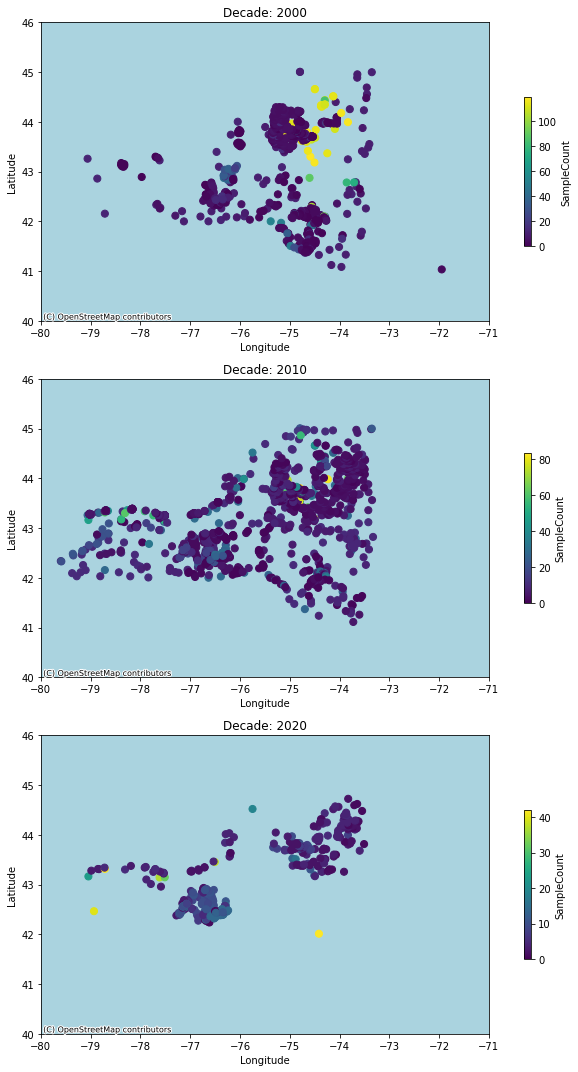

In [79]:
plot_data(decade_dfs_group,'SampleCount')

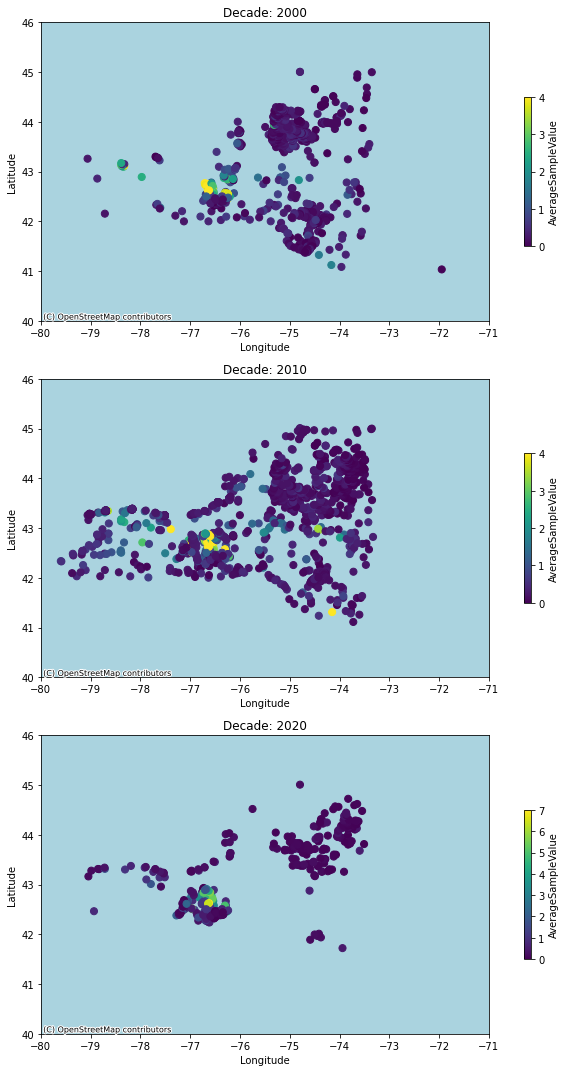

In [80]:
plot_data(decade_gdfs_group,'AverageSampleValue')

## 5. Obtaining Watershed Data

In [19]:
all_points = loc_stats(units_adjusted_df)
points_gdf = gpd.GeoDataFrame(all_points, geometry=gpd.points_from_xy(all_points['Longitude'], all_points['Latitude']))

In [20]:
'''Creating input files for USGS stream stats batch processor'''

import zipfile

# Define the GeoDataFrame
shed_gdf = points_gdf[['MonitoringLocationIdentifier', 'geometry']]

chunk_size = 250

# Split the GeoDataFrame into 7 chunks of 250 values each and one with the remaining
shed_gdfs = [shed_gdf.iloc[i:i + chunk_size] for i in range(0, 7 * chunk_size, chunk_size)]

# Add the remaining values to the last chunk
shed_gdfs.append(shed_gdf.iloc[7 * chunk_size:])

# Directory to save the shapefiles
output_dir = path+'watershed'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Export each chunk to separate shapefiles and zip them
for idx, chunk in enumerate(shed_gdfs):
    shapefile_path = os.path.join(output_dir, f'gdf_part_{idx + 1}.shp')
    chunk.to_file(shapefile_path)
    
    # Create a zip file
    zip_filename = os.path.join(output_dir, f'gdf_part_{idx + 1}.zip')
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for extension in ['shp', 'shx', 'dbf', 'prj', 'cpg']:
            file_to_zip = shapefile_path.replace('.shp', f'.{extension}')
            if os.path.exists(file_to_zip):
                zipf.write(file_to_zip, os.path.basename(file_to_zip))

print("Shapefiles and zip files created successfully.")

Shapefiles and zip files created successfully.


<ipython-input-20-e9794bbf98f1>:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  chunk.to_file(shapefile_path)


In [21]:
'''Loading in Watershed outputs from USGS streamstats batch processor'''

# List of filenames to load
filenames = ['1','2','3', '4', '5','6','7','8']

# Function to load GeoDataFrames from a given file and layers
def load_gdf(file_path):
    layers = fiona.listlayers(file_path)
    data = [gpd.read_file(file_path, layer=layer) for layer in layers]
    return data

# Initialize lists to hold the GeoDataFrames
shed_data_list = []
shed_points_list = []

# Iterate over the filenames and load the GeoDataFrames
for i in filenames:
    watershed_path = os.path.join(path+'watershed_outputs/gdf_part_'+i+'/gdf_part_'+i+'.gdb')
    shed_points, shed_data = load_gdf(watershed_path)
    shed_data_list.append(shed_data)
    shed_points_list.append(shed_points)

# Concatenate the loaded GeoDataFrames
shed_data_df = gpd.GeoDataFrame(pd.concat(shed_data_list, ignore_index=True))
shed_points_df = gpd.GeoDataFrame(pd.concat(shed_points_list, ignore_index=True))

In [22]:
points_gdf_shed = points_gdf.rename(columns={'MonitoringLocationIdentifier':'Name'})
points_gdf_shed = points_gdf_shed.merge(shed_data_df, on = 'Name', suffixes=('_point', '_polygon'), how= 'right')
points_gdf_shed =gpd.GeoDataFrame(points_gdf_shed)

## 6. Getting crop and tile drainage spatial data (done in QGIS)

## 7. Formatting Spatial Data in Python

In [23]:
crops = gpd.read_file('/Users/amitanand/Downloads/research_summer_2024/spatial/crops/nys_crops_100_points.shp')

In [24]:
tile = gpd.read_file('/Users/amitanand/Downloads/research_summer_2024/spatial/tile/tile_100_points.shp')

In [25]:
tile_gdf = gpd.GeoDataFrame(tile)


In [26]:
crops_gdf = gpd.GeoDataFrame(crops)

In [27]:
# Set geometry_polygon as active geometry
points_gdf_shed.set_geometry('geometry_polygon', inplace=True)
points_gdf_shed = points_gdf_shed.to_crs("EPSG:3857")

In [28]:
crops_gdf = crops_gdf.to_crs("EPSG:3857")

In [29]:
tile_gdf = tile_gdf.to_crs("EPSG:3857")

In [30]:
def percent_in_poly(points_gdf, polygons_gdf, name):
    # Ensure both GeoDataFrames have the same CRS
    if polygons_gdf.crs != points_gdf.crs:
        points_gdf = points_gdf.to_crs(polygons_gdf.crs)

    # Perform a spatial join to find points within polygons

    points_within_polygons = gpd.sjoin(points_gdf, polygons_gdf, how="inner", predicate="within")
    print(points_within_polygons.columns)

    # Count total points in each polygon
    total_points_count = points_within_polygons['index_right'].value_counts()

    # Count points with value 1 in each polygon
    points_with_value_1 = points_within_polygons[points_within_polygons['VALUE'] == 1]
    points_with_value_1_count = points_with_value_1['index_right'].value_counts()

    # Create a DataFrame for the counts
    counts_df = pd.DataFrame({
        'total_points': total_points_count,
        'points_with_value_1': points_with_value_1_count
    })

    # Calculate the coverage percentage
    counts_df['coverage_percentage'+name] = (counts_df['points_with_value_1'] / counts_df['total_points']) * 100

    # Merge the coverage percentage back into the original polygons GeoDataFrame
    polygons_gdf = polygons_gdf.merge(counts_df['coverage_percentage'+name], left_index=True, right_index=True, how='left').fillna(0)

    return polygons_gdf

In [31]:
# Running the above function for Watersheds
points_gdf_shed.set_geometry('geometry_polygon', inplace= True)
points_gdf_shed_crop = percent_in_poly(crops_gdf,points_gdf_shed,'crop')
points_gdf_shed_final = percent_in_poly(tile_gdf, points_gdf_shed_crop,'tile')

Index(['VALUE', 'geometry', 'index_right', 'Name', 'MinSampleDate',
       'MaxSampleDate', 'Latitude', 'Longitude', 'AverageSampleValue',
       'SampleCount', 'geometry_point', 'HydroID', 'DrainID', 'Descript',
       'GlobalWshd', 'RELATEDOIDS', 'WarningMsg', 'HUCID', 'Edited',
       'Shape_Length', 'Shape_Area', 'FOREST', 'DRNAREA'],
      dtype='object')
Index(['VALUE', 'geometry', 'index_right', 'Name', 'MinSampleDate',
       'MaxSampleDate', 'Latitude', 'Longitude', 'AverageSampleValue',
       'SampleCount', 'geometry_point', 'HydroID', 'DrainID', 'Descript',
       'GlobalWshd', 'RELATEDOIDS', 'WarningMsg', 'HUCID', 'Edited',
       'Shape_Length', 'Shape_Area', 'FOREST', 'DRNAREA',
       'coverage_percentagecrop'],
      dtype='object')


In [32]:
# getting proportion of tile drainage column (restricted to watersheds that have greater than 0% crop cover)
tile_edit_shed = points_gdf_shed_final['coverage_percentagetile'].loc[points_gdf_shed_final['coverage_percentagetile']>0]
crop_edit_shed = points_gdf_shed_final['coverage_percentagecrop'].loc[points_gdf_shed_final['coverage_percentagecrop']>0]
points_gdf_shed_final['tile_proportion'] = tile_edit_shed/crop_edit_shed
points_gdf_shed_final['tile_proportion'] = points_gdf_shed_final['tile_proportion'].loc[points_gdf_shed_final['tile_proportion']<=1]



In [33]:
def plot_polys(poly_gdf,parameter, name):
    
    '''Plot_polys() plots a gdf with polygons  based on a given parameter and colors this parameter
    '''
    
    # Define the custom colormap
    cmap = plt.get_cmap('Reds')  # Base colormap
    cmap.set_bad(color='grey')  # Color for NaN values

    # Convert parameter column to float and set NaNs for missing data
    poly_gdf[parameter] = poly_gdf[parameter].astype(float)
    poly_gdf[parameter] = poly_gdf[parameter].replace([np.inf, -np.inf], np.nan)

    # Plot with custom colormap
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    poly_gdf.plot(column=parameter, cmap=cmap, legend=True, ax=ax, missing_kwds={"color": "grey", "label": "No data"})

    # Add title and show plot
    plt.title(name+ ' 2000 - Present')
    plt.show()

<ipython-input-33-3a5267edee84>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  cmap.set_bad(color='grey')  # Color for NaN values


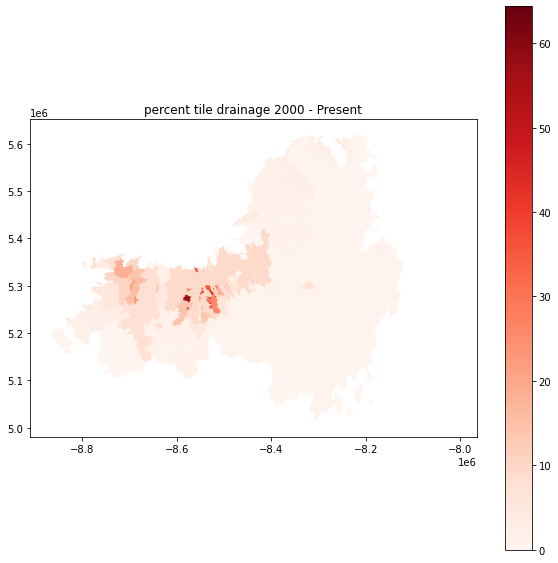

In [34]:
plot_polys(points_gdf_shed_final,'coverage_percentagetile','percent tile drainage')

<ipython-input-33-3a5267edee84>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  cmap.set_bad(color='grey')  # Color for NaN values


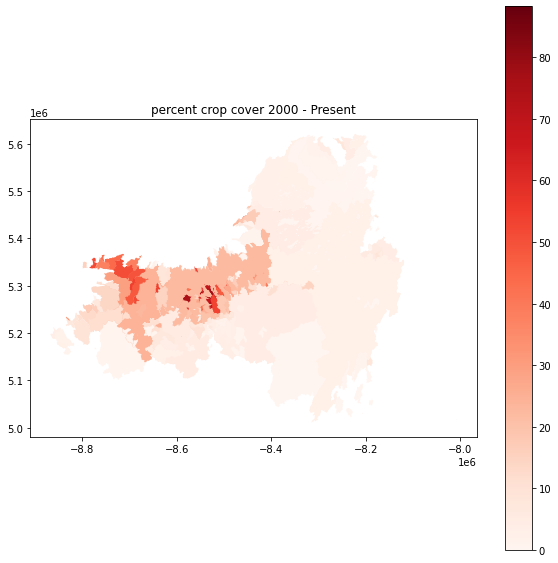

In [35]:
plot_polys(points_gdf_shed_final,'coverage_percentagecrop','percent crop cover')

<ipython-input-33-3a5267edee84>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  cmap.set_bad(color='grey')  # Color for NaN values


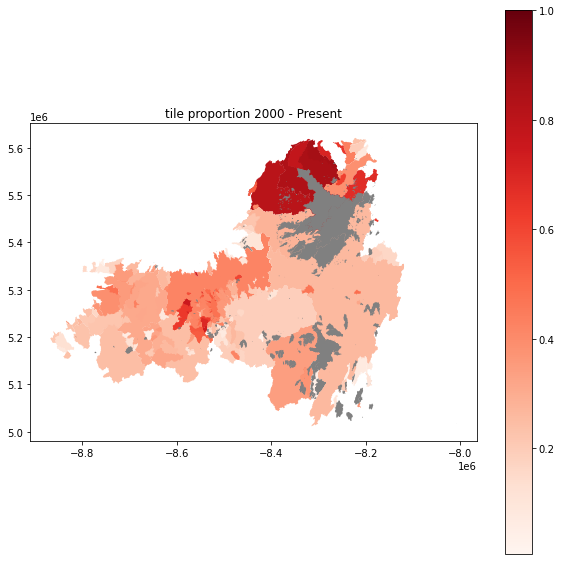

In [36]:
plot_polys(points_gdf_shed_final,'tile_proportion','tile proportion')

## 8. Statistical Analysis

In [131]:
def get_reg_vars(gdf, value_name, samp_name):
    
    # Removing 0 values and replacing with np.nan (signifies no data)
    gdf.loc[gdf['coverage_percentagecrop'] == 0, 'coverage_percentagecrop'] = np.nan
    gdf.loc[gdf[value_name] == 0, value_name] = np.nan
    gdf.loc[gdf['coverage_percentagetile'] == 0, 'coverage_percentagetile'] = np.nan

    # Getting variables (fewer tile_proportion values due to undefineds)
    y_prop = gdf[value_name].loc[gdf['tile_proportion'] > 0].dropna()
    w_prop = gdf[samp_name].loc[gdf['tile_proportion'] > 0].dropna()
    x_crop = gdf[['coverage_percentagecrop']].dropna()
    x_tile = gdf[['coverage_percentagetile']].dropna()
    x_prop = gdf[['tile_proportion']].dropna()
    y = gdf[[value_name]].dropna()
    w = gdf[samp_name].dropna()
    
    return y_prop, w_prop, x_crop, x_tile, x_prop, y, w



y_prop, w_prop, x_crop, x_tile, x_prop, y, w = get_reg_vars(points_gdf_shed_final, 'AverageSampleValue', 'SampleCount')





In [132]:
def interact_term(x1,x2,y,w,x2name):

    # Align all DataFrames on the common index
    common_index = y.index.intersection(x1.index).intersection(x2.index).intersection(w.index)
    y = y.loc[common_index]
    w = w.loc[common_index]
    x1 = x1.loc[common_index]
    x2 = x2.loc[common_index]

    # Compute the interaction term
    interact = x1['coverage_percentagecrop'] * x2[x2name]
    
    return x1,x2,y,w,interact


In [151]:
'''-----Test 1-----
Crop Cover vs Tile Drained Area vs Nitrogen'''

x_crop_star, x_tile_star, y_star, w_star, x_interact_crop_tile = interact_term(x_crop,x_tile,y,w,'coverage_percentagetile')

# Combine x_crop, x_tile, and the interaction term into a single DataFrame
#X = pd.concat([x_crop_star, x_tile_star, x_interact_crop_tile.rename('interact_crop_tile')], axis=1)
X_test_1 = pd.concat([x_crop, x_tile], axis=1)


# Ensure there are no NaNs in the combined DataFrame
X_test_1 = X_test_1.dropna()
y_star = np.log(y_star.loc[X_test_1.index])
w_star = w_star.loc[X_test_1.index]

# Add a constant term for the intercept
X_test_1 = sm.add_constant(X_test_1)

# Fit the multiple linear regression model
model = sm.WLS(y_star, X_test_1, weights=w_star).fit()
model = sm.OLS(y_star, X_test_1).fit()


# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     AverageSampleValue   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     193.2
Date:                Wed, 07 Aug 2024   Prob (F-statistic):           8.12e-66
Time:                        10:45:28   Log-Likelihood:                -815.11
No. Observations:                 617   AIC:                             1636.
Df Residuals:                     614   BIC:                             1649.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [135]:
'''-----Test 2-----
crop cover vs proportion tile drainage vs nitrogen'''
x_crop_star, x_prop_star, y_star, w_star, x_interact_crop_tile = interact_term(x_crop,x_prop,y,w,'tile_proportion')

# Combine x_crop, x_tile, and the interaction term into a single DataFrame
#X = pd.concat([x_crop_star, x_prop_star, x_interact_crop_prop.rename('interact_crop_prop')], axis=1)
X_test_2 = pd.concat([x_crop_star, x_prop_star], axis=1)


# Ensure there are no NaNs in the combined DataFrame
X_test_2 = X_test_2.dropna()
y_star = np.log(y_star.loc[X_test_2.index])
w_star = w_star.loc[X_test_2.index]

# Add a constant term for the intercept
X_test_2 = sm.add_constant(X_test_2)

# Fit the multiple linear regression model
model = sm.WLS(y_star, X_test_2, weights=w_star).fit()
model = sm.OLS(y_star, X_test_2).fit()


# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     AverageSampleValue   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     185.2
Date:                Wed, 07 Aug 2024   Prob (F-statistic):           1.67e-63
Time:                        10:22:53   Log-Likelihood:                -809.61
No. Observations:                 609   AIC:                             1625.
Df Residuals:                     606   BIC:                             1638.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     